In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,  roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

In [11]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [12]:
models = {'rf': RandomForestClassifier(random_state=42),
          'xgb': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_v1': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_v1_03': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc')}

c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [13]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [14]:
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [15]:
def evaluate_model(model):
    final_proba = model.predict_proba(test)
    final_proba = final_proba[:, 1]
    final_preds = model.predict(test)
    print(f'Accuracy:', f'{accuracy_score(final_actual, final_preds):.3f}')
    print(f'Precision:', f'{precision_score(final_actual, final_preds):.3f}')
    print(f'Recall:', f'{recall_score(final_actual, final_preds):.3f}')
    print(f'ROC-AUC:', f'{roc_auc_score(final_actual, final_proba):.3f}')

In [16]:
"""rf_params = {'rf__n_estimators': [100, 200, 300, 400, 500],
             'rf__max_depth': [10, 20, 30, 40, 50, 60],
             'rf__min_samples_leaf': [i for i in range(2, 18)],
            }
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)
#joblib.dump(rf_gs[1], "./model/rf_modified.joblib")"""

'rf_params = {\'rf__n_estimators\': [100, 200, 300, 400, 500],\n             \'rf__max_depth\': [10, 20, 30, 40, 50, 60],\n             \'rf__min_samples_leaf\': [i for i in range(2, 18)],\n            }\nrf_gs =  run_model(\'rf\', mod_params=rf_params, grid_search=True)\n#joblib.dump(rf_gs[1], "./model/rf_modified.joblib")'

# Random Forest Model


- UNModified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [17]:
X_graph = []
y_graph = []

In [18]:
train = pd.read_pickle('./feature/feat_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_v1 = run_model('rf')
rf_v1_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [20],
             'rf__min_samples_leaf': [2],
            }
rf_gs_v1 = run_model('rf', mod_params=rf_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])
evaluate_model(rf_gs_v1)

"""
rf_gs_v1.fit(X, y)
print(' ')
evaluate_model(rf_gs_v1)
"""

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999999648146146,
 'test_auc': 0.8861427964945664,
 'precision': 0.757903324495207,
 'specificity': 0.9088535667664901,
 'recall': 0.6249579549276825,
 'f_score': 0.6850400958613697}

True Negatives: 11836
False Positives: 1187
False Negatives: 2230
True Positives: 3716
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9945258882383992,
 'test_auc': 0.8893295178891113,
 'precision': 0.7667644593461861,
 'specificity': 0.9145358212393457,
 'recall': 0.6153716784392869,
 'f_score': 0.6827766374323568}

True Negatives: 11910
False Positives: 1113
False Negatives: 2287
True Positives: 3659
Accuracy: 0.806
Precision: 0.761
Recall: 0.566
ROC-AUC: 0.879


"\nrf_gs_v1.fit(X, y)\nprint(' ')\nevaluate_model(rf_gs_v1)\n"

<AxesSubplot:>

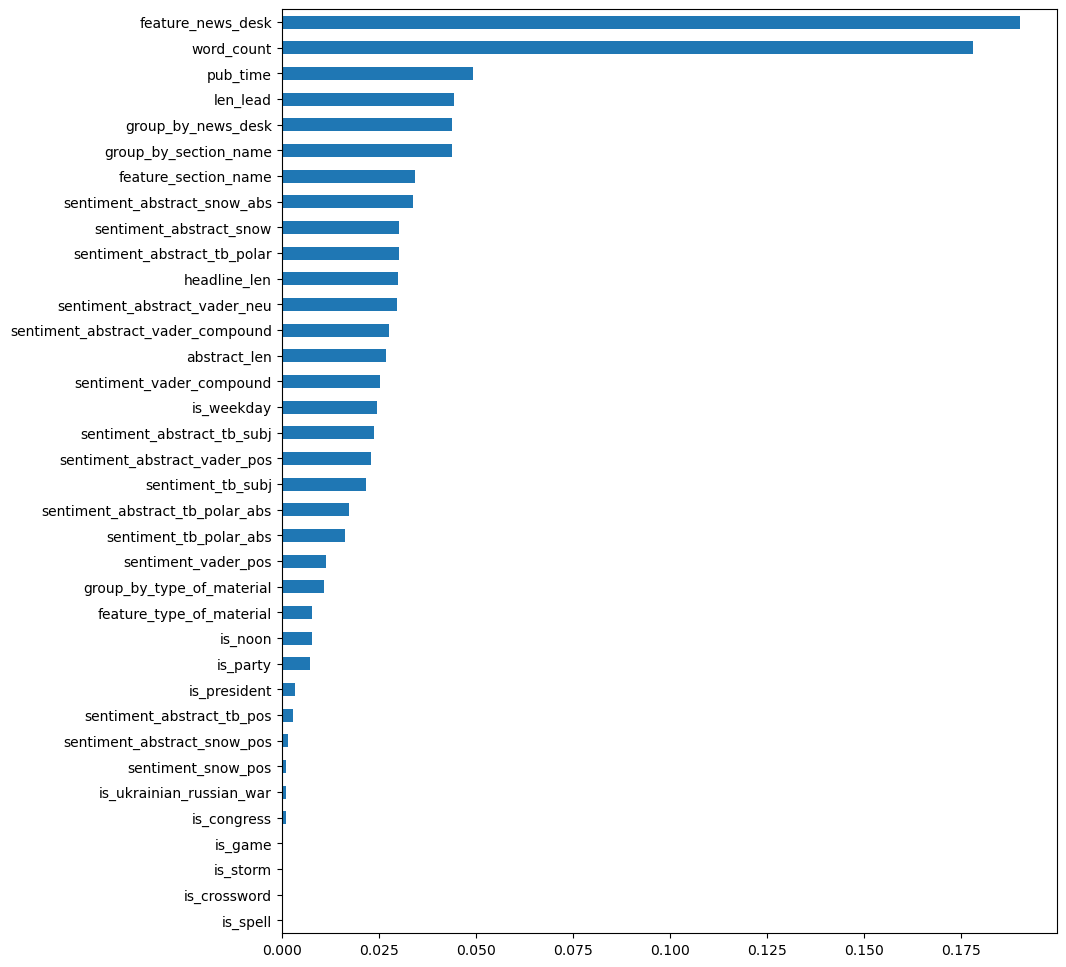

In [19]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_v1[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- Unmodified Version2<br/>
The dataset has 30% is_popular data, as same as the modified dataset.

In [20]:
train = pd.read_pickle('./feature/feat_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_v2 = run_model('rf')
rf_v2_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [25],
             'rf__min_samples_leaf': [2],
            }
rf_gs_v2 = run_model('rf', mod_params=rf_v2_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
evaluate_model(rf_gs_v2)

"""
rf_gs_v2.fit(X, y)
print(' ')
evaluate_model(rf_gs_v2)
"""

### METRICS ###


{'model': 'rf',
 'train_auc': 1.0,
 'test_auc': 0.86937673076168,
 'precision': 0.7567805953693495,
 'specificity': 0.9150296587319929,
 'recall': 0.5731462925851704,
 'f_score': 0.6522854699230257}

True Negatives: 11878
False Positives: 1103
False Negatives: 2556
True Positives: 3432
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=25, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9992118437351512,
 'test_auc': 0.8714927801318169,
 'precision': 0.7645997745208568,
 'specificity': 0.9195747631153224,
 'recall': 0.5662992651970608,
 'f_score': 0.6506763887556366}

True Negatives: 11937
False Positives: 1044
False Negatives: 2597
True Positives: 3391
Accuracy: 0.796
Precision: 0.754
Recall: 0.530
ROC-AUC: 0.864


"\nrf_gs_v2.fit(X, y)\nprint(' ')\nevaluate_model(rf_gs_v2)\n"

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [21]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v1 = run_model('rf')
rf_mod_v1_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [15],
             'rf__min_samples_leaf': [7],
            }
rf_gs_mod_v1 = run_model('rf', mod_params=rf_mod_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])
evaluate_model(rf_gs_mod_v1)

"""
rf_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v1)
"""

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999143583927594,
 'test_auc': 0.8459441627387693,
 'precision': 0.7375669472073451,
 'specificity': 0.91921808761187,
 'recall': 0.5391498881431768,
 'f_score': 0.6229402261712439}

True Negatives: 3903
False Positives: 343
False Negatives: 824
True Positives: 964
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=15, min_samples_leaf=7, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9427084962223582,
 'test_auc': 0.8512702704269105,
 'precision': 0.7505863956215794,
 'specificity': 0.9248704663212435,
 'recall': 0.5369127516778524,
 'f_score': 0.6260189109879362}

True Negatives: 3927
False Positives: 319
False Negatives: 828
True Positives: 960
Accuracy: 0.675
Precision: 0.889
Recall: 0.400
ROC-AUC: 0.827


"\nrf_gs_mod_v1.fit(X, y)\nprint(' ')\nevaluate_model(rf_gs_mod_v1)\n"

- Modified Version1.03<br/>

In [22]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v1_03 = run_model('rf')
rf_mod_v1_03_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [20],
             'rf__min_samples_leaf': [6],
            }
rf_gs_mod_v1_03 = run_model('rf', mod_params=rf_mod_v1_03_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])
evaluate_model(rf_gs_mod_v1_03)
"""
rf_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v1_03)
"""

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9998967887426946,
 'test_auc': 0.8473006835753296,
 'precision': 0.7346938775510204,
 'specificity': 0.9173339613754121,
 'recall': 0.5436241610738255,
 'f_score': 0.6248794599807136}

True Negatives: 3895
False Positives: 351
False Negatives: 816
True Positives: 972
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=6, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9648102452744619,
 'test_auc': 0.8537037359019832,
 'precision': 0.7452326468344775,
 'specificity': 0.9213377296278851,
 'recall': 0.546420581655481,
 'f_score': 0.6305259761213294}

True Negatives: 3912
False Positives: 334
False Negatives: 811
True Positives: 977
Accuracy: 0.678
Precision: 0.886
Recall: 0.408
ROC-AUC: 0.827
 
Accuracy: 0.676
Precision: 0.892
Recall: 0.398
ROC-AUC: 0.827


- Modified Version2<br/>

In [23]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v2 = run_model('rf')
rf_mod_v2_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [15],
             'rf__min_samples_leaf': [1],
            }
rf_gs_mod_v2 = run_model('rf', mod_params=rf_mod_v2_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])

evaluate_model(rf_gs_mod_v2)
"""
rf_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v2)
"""

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999998284473005,
 'test_auc': 0.8429653496469678,
 'precision': 0.7760589318600368,
 'specificity': 0.8025974025974026,
 'recall': 0.7132701421800948,
 'f_score': 0.743340977244664}

True Negatives: 2472
False Positives: 608
False Negatives: 847
True Positives: 2107
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=15, n_estimators=300, random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.982928881698207,
 'test_auc': 0.8465188078678262,
 'precision': 0.7809094325441563,
 'specificity': 0.8107142857142857,
 'recall': 0.7034529451591063,
 'f_score': 0.7401602849510239}

True Negatives: 2497
False Positives: 583
False Negatives: 876
True Positives: 2078
Accuracy: 0.755
Precision: 0.785
Recall: 0.701
ROC-AUC: 0.846


"\nrf_gs_mod_v2.fit(X, y)\nprint(' ')\nevaluate_model(rf_gs_mod_v2)\n"

# XGBoost Model

- Unmodified Version1

In [24]:
train = pd.read_pickle('./feature/feat_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb = run_model('xgb')
xgb_v1_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [1.0], 
              'xgb__gamma' : [2.5],
            }
xgb_gs_v1 = run_model('xgb', mod_params=xgb_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_v1)
"""
xgb_gs_v1.fit(X, y)
print(' ')
evaluate_model(xgb_gs_v1)
"""

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9445394233524427,
 'test_auc': 0.8819288813429236,
 'precision': 0.7268457636671051,
 'specificity': 0.8883513783306458,
 'recall': 0.6506895391860074,
 'f_score': 0.6866625255124679}

True Negatives: 11569
False Positives: 1454
False Negatives: 2077
True Positives: 3869
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9225078726361484,
 'test_auc': 0.8847406677502627,
 'precision': 0.7348139711465452,
 'specificity': 0.8927282500191968,
 'recall': 0.6510258997645476,
 'f_score': 0.6903870162297129}

True Negatives: 11626
False Positives: 1397
False Negatives: 2075
True Positives: 3871
Accuracy: 0.808
Precision: 0.738
Recall: 0.610
ROC-AUC: 0.880


"\nxgb_gs_v1.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_v1)\n"

- Unmodified Version2

In [25]:
train = pd.read_pickle('./feature/feat_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb = run_model('xgb')
xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], 
              'xgb__max_depth' : [3, 5], 
              'xgb__n_estimators' : [100, 200, 300], 
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], 
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], 
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], 
            }
xgb_v2_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5], 
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [2.0], 
            }
xgb_gs_v2 = run_model('xgb', mod_params=xgb_v2_param, grid_search=True)
#xgb_gs[1].save_model('./model/xgb_v2.json')
test = pd.read_pickle('./feature/feat_test_v2.pkl')
test = test._get_numeric_data()
final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])

evaluate_model(xgb_gs_v2)
"""
xgb_gs_v2.fit(X, y)
print(' ')
evaluate_model(xgb_gs_v2)
"""

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9389483633869015,
 'test_auc': 0.8670054653641308,
 'precision': 0.7253210272873194,
 'specificity': 0.8945381711732532,
 'recall': 0.6037074148296593,
 'f_score': 0.6589500546846518}

True Negatives: 11612
False Positives: 1369
False Negatives: 2373
True Positives: 3615
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.911770113551799,
 'test_auc': 0.8700543950546498,
 'precision': 0.7370672097759674,
 'specificity': 0.9005469532393499,
 'recall': 0.60437541750167,
 'f_score': 0.6641585612038906}

True Negatives: 11690
False Positives: 1291
False Negatives: 2369
True Positives: 3619
Accuracy: 0.796
Precision: 0.722
Recall: 0.579
ROC-AUC: 0.867


"\nxgb_gs_v2.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_v2)\n"

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [26]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v1 = run_model('xgb')
xgb_mod_v1_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [100], 
              'xgb__reg_alpha' : [1.8], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [1.0],
            }
xgb_gs_mod_v1 = run_model('xgb', mod_params=xgb_mod_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_mod_v1)
"""
xgb_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v1)
"""


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9750533631900492,
 'test_auc': 0.8394286871918404,
 'precision': 0.7098214285714286,
 'specificity': 0.9081488459726802,
 'recall': 0.5335570469798657,
 'f_score': 0.6091954022988506}

True Negatives: 3856
False Positives: 390
False Negatives: 834
True Positives: 954
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.8957814876576966,
 'test_auc': 0.8495945256016716,
 'precision': 0.7450826121164438,
 'specificity': 0.9236928874234573,
 'recall': 0.5296420581655481,
 'f_score': 0.6191565871199739}

True Negatives: 3922
False Positives: 324
False Negatives: 841
True Positives: 947
Accuracy: 0.675
Precision: 0.899
Recall: 0.393
ROC-AUC: 0.823


"\nxgb_gs_mod_v1.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_mod_v1)\n"

- Modified Version1.03</br>
The dataset has 30% is_popular data, as same as the unmodified dataset.

In [27]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v1_03 = run_model('xgb')
xgb_mod_v1_03_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [200], 
              'xgb__reg_alpha' : [1.8], 
              'xgb__reg_lambda' : [0.1], 
              'xgb__gamma' : [3.0],
            }
xgb_gs_mod_v1_03 = run_model('xgb', mod_params=xgb_mod_v1_03_param, grid_search=True)

test = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_mod_v1_03)
"""
xgb_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v1_03)
"""


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9812659580551263,
 'test_auc': 0.8361775683601674,
 'precision': 0.7004437869822485,
 'specificity': 0.9046161092793217,
 'recall': 0.5296420581655481,
 'f_score': 0.6031847133757963}

True Negatives: 3841
False Positives: 405
False Negatives: 841
True Positives: 947
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9078018478405325,
 'test_auc': 0.8514977512721541,
 'precision': 0.7408844065166796,
 'specificity': 0.9213377296278851,
 'recall': 0.5341163310961968,
 'f_score': 0.620734481637959}

True Negatives: 3912
False Positives: 334
False Negatives: 833
True Positives: 955
Accuracy: 0.680
Precision: 0.900
Recall: 0.405
ROC-AUC: 0.827


"\nxgb_gs_mod_v1_03.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_mod_v1_03)\n"

- Modified Version2

In [28]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v2 = run_model('xgb')
xgb_params = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5], 
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [2.0], 
            }
xgb_gs_mod_v2 = run_model('xgb', mod_params=xgb_params, grid_search=True)
xgb_gs_mod_v2[1].save_model('./model/xgb_modified_v2.json')

test = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])

evaluate_model(xgb_gs_mod_v2)
"""
xgb_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v2)
"""


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9745069257540302,
 'test_auc': 0.833544544487334,
 'precision': 0.7451388888888889,
 'specificity': 0.7616883116883116,
 'recall': 0.7264725795531483,
 'f_score': 0.7356873500171409}

True Negatives: 2346
False Positives: 734
False Negatives: 808
True Positives: 2146
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9291171290587124,
 'test_auc': 0.8419028458001037,
 'precision': 0.7605683836589698,
 'specificity': 0.7811688311688312,
 'recall': 0.7247799593771158,
 'f_score': 0.7422430230542556}

True Negatives: 2406
False Positives: 674
False Negatives: 813
True Positives: 2141
Accuracy: 0.757
Precision: 0.769
Recall: 0.734
ROC-AUC: 0.846


"\nxgb_gs_mod_v2.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_mod_v2)\n"

In [29]:
"""
xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], 
              'xgb__max_depth' : [3, 5], 
              'xgb__n_estimators' : [100, 200, 300], 
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], 
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], 
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], 
            }
xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)
xgb_gs[1].save_model('./model/xgb.json')"""

"\nxgb_params = { \n              'xgb__learning_rate' : [0.1, 0.2, 0.3], \n              'xgb__max_depth' : [3, 5], \n              'xgb__n_estimators' : [100, 200, 300], \n              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], \n              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], \n              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], \n            }\nxgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)\nxgb_gs[1].save_model('./model/xgb.json')"

In [30]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf,1.000000,0.886143,0.757903,0.908854,0.624958,0.685040
1,xgb,0.944539,0.881929,0.726846,0.888351,0.650690,0.686663
2,rf,1.000000,0.869377,0.756781,0.915030,0.573146,0.652285
3,xgb,0.938948,0.867005,0.725321,0.894538,0.603707,0.658950
4,rf,0.999897,0.847301,0.734694,0.917334,0.543624,0.624879
5,rf,0.999914,0.845944,0.737567,0.919218,0.539150,0.622940
6,rf,1.000000,0.842965,0.776059,0.802597,0.713270,0.743341
7,xgb,0.975053,0.839429,0.709821,0.908149,0.533557,0.609195
8,xgb,0.981266,0.836178,0.700444,0.904616,0.529642,0.603185
9,xgb,0.974507,0.833545,0.745139,0.761688,0.726473,0.735687


In [31]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf,0.994526,0.889330,0.766764,0.914536,0.615372,0.682777
5,xgb,0.922508,0.884741,0.734814,0.892728,0.651026,0.690387
1,rf,0.999212,0.871493,0.764600,0.919575,0.566299,0.650676
6,xgb,0.911770,0.870054,0.737067,0.900547,0.604375,0.664159
3,rf,0.964810,0.853704,0.745233,0.921338,0.546421,0.630526
8,xgb,0.907802,0.851498,0.740884,0.921338,0.534116,0.620734
2,rf,0.942708,0.851270,0.750586,0.924870,0.536913,0.626019
7,xgb,0.895781,0.849595,0.745083,0.923693,0.529642,0.619157
4,rf,0.982929,0.846519,0.780909,0.810714,0.703453,0.740160
9,xgb,0.929117,0.841903,0.760568,0.781169,0.724780,0.742243


In [32]:
gs_dict = {
    rf_gs_v1: 'RandomForest Unmodified V1',
    rf_gs_v2: 'RandomForest Unmodified V2',
    rf_gs_mod_v1: 'RandomForest Modified V1',
    rf_gs_mod_v1_03: 'RandomForest Modified V1-0.3',
    rf_gs_mod_v2: 'RandomForest Modified V2',
    xgb_gs_v1: 'XGBoostClassfier Unmodified V1',
    xgb_gs_v2: 'XGBoostClassfier Unmodified V2',
    xgb_gs_mod_v1: 'XGBoostClassfier Modified V1',
    xgb_gs_mod_v1_03: 'XGBoostClassfier Modified V1-0.3',
    xgb_gs_mod_v2: 'XGBoostClassfier Modified V2',
}

In [33]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = sklearn.metrics.RocCurveDisplay.from_estimator(m, X_graph[i], y_graph[i], ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

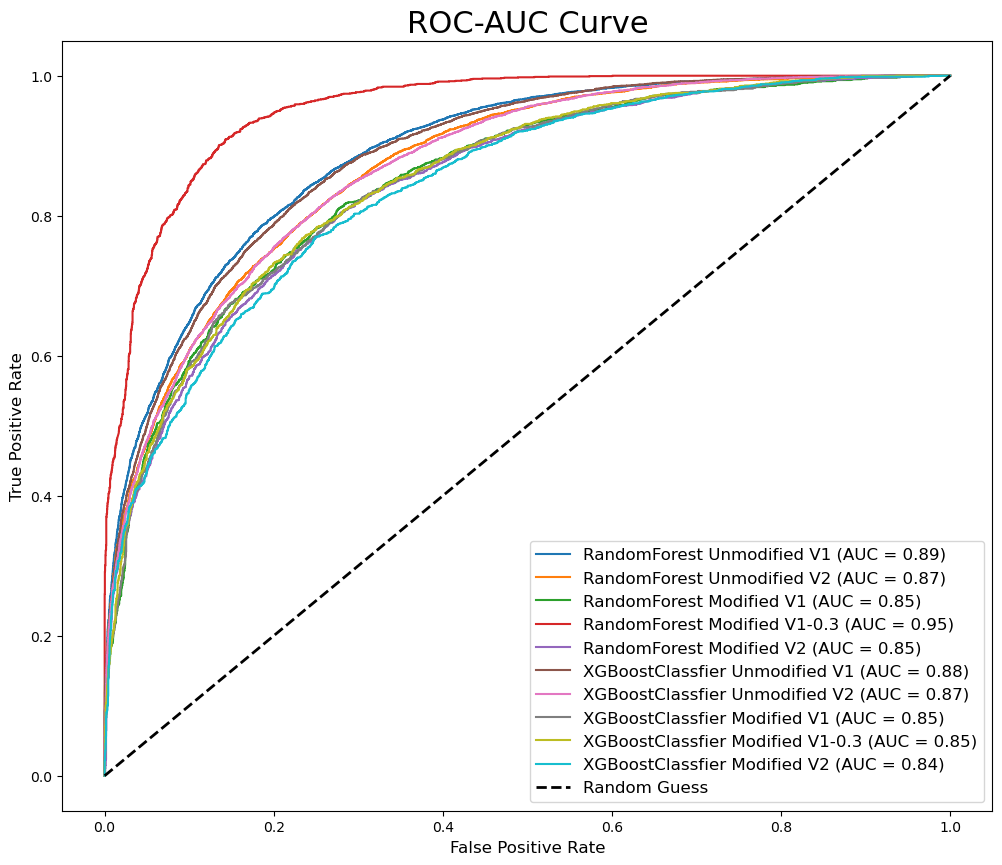

In [34]:
roc_curve_plotter(gs_dict, False)